In [1]:
import os, sys
import numpy as np
import torch
from data_loader import *
from preprocess.acf import *
from preprocess.gaussianize import *
from model import *
import matplotlib.pyplot as plt
import yaml
import joblib
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"  
device = torch.device(dev)
from scipy.stats import wasserstein_distance


In [2]:
root = "./QuantGAN"
sys.path.append(root)

file_name = 'SP500_daily'
wandb_name = 'snowy-flower-196'
generator_path = f'./result/{file_name}_{wandb_name}'
num_epochs = 400

In [3]:
standardScaler1 = joblib.load(f'./data/pickle/{file_name}_standardScaler1.pkl')
standardScaler2 = joblib.load(f'./data/pickle/{file_name}_standardScaler2.pkl')
gaussianize = joblib.load(f'./data/pickle/{file_name}_gaussianize.pkl')
log_returns = joblib.load(f'./data/pickle/{file_name}_log_returns.pkl')
log_returns_preprocessed = joblib.load(f'./data/pickle/{file_name}_log_returns_preprocessed.pkl')

In [4]:
# Find the best epoch
noise = torch.randn(80, 3, 756).to(device)
min_emd = 0
best_epochs = 0
min_distance = float('inf')

for epoch in range(0, num_epochs, 5):   
    generator_tmp = torch.load(f'{generator_path}/epoch_{epoch}.pth')   
    generator_tmp.eval()
     
    y = generator_tmp(noise).cpu().detach().squeeze()
    y = (y - y.mean(axis=0))/y.std(axis=0)
    y = standardScaler2.inverse_transform(y)
    y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
    y = standardScaler1.inverse_transform(y)
    if y.size == 0:            
        continue
    
    window = 100
    real_dist = rolling_window(log_returns, window, sparse = not (window == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, window, sparse = not (window == 1)).sum(axis=0).ravel()        
    
    emd = wasserstein_distance(real_dist, fake_dist)
    if emd < min_distance:
        min_distance = emd
        best_epochs = epoch
        generator = generator_tmp
        min_emd = min_distance
        print(f"min_distance:{min_distance}, best_epochs:{epoch}")
        
print(best_epochs)

min_distance:0.07110238973419929, best_epochs:0
min_distance:0.0330482103440666, best_epochs:15
min_distance:0.024642553435406243, best_epochs:130
min_distance:0.016092029246742134, best_epochs:135
min_distance:0.015497648730551525, best_epochs:265
265


In [5]:
# generate the data based on best epoch
generator = torch.load(f'{generator_path}/epoch_{best_epochs}.pth')   
generator.eval()

y = generator(noise).cpu().detach().squeeze()
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
#y -= y.mean()
print(y.shape)

(78, 756)


Text(0, 0.5, 'Cumalative log return')

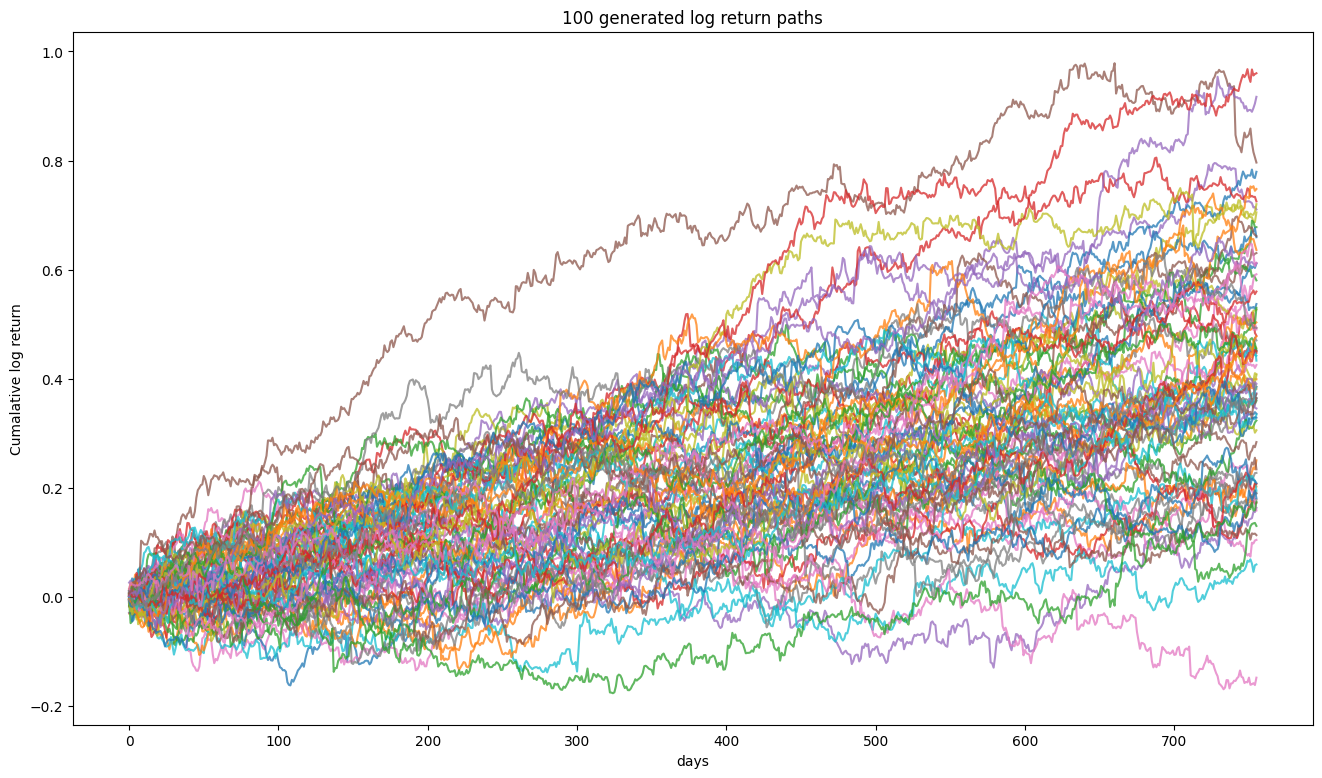

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:], axis=1).T, alpha=0.75)
ax.set_title('100 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')

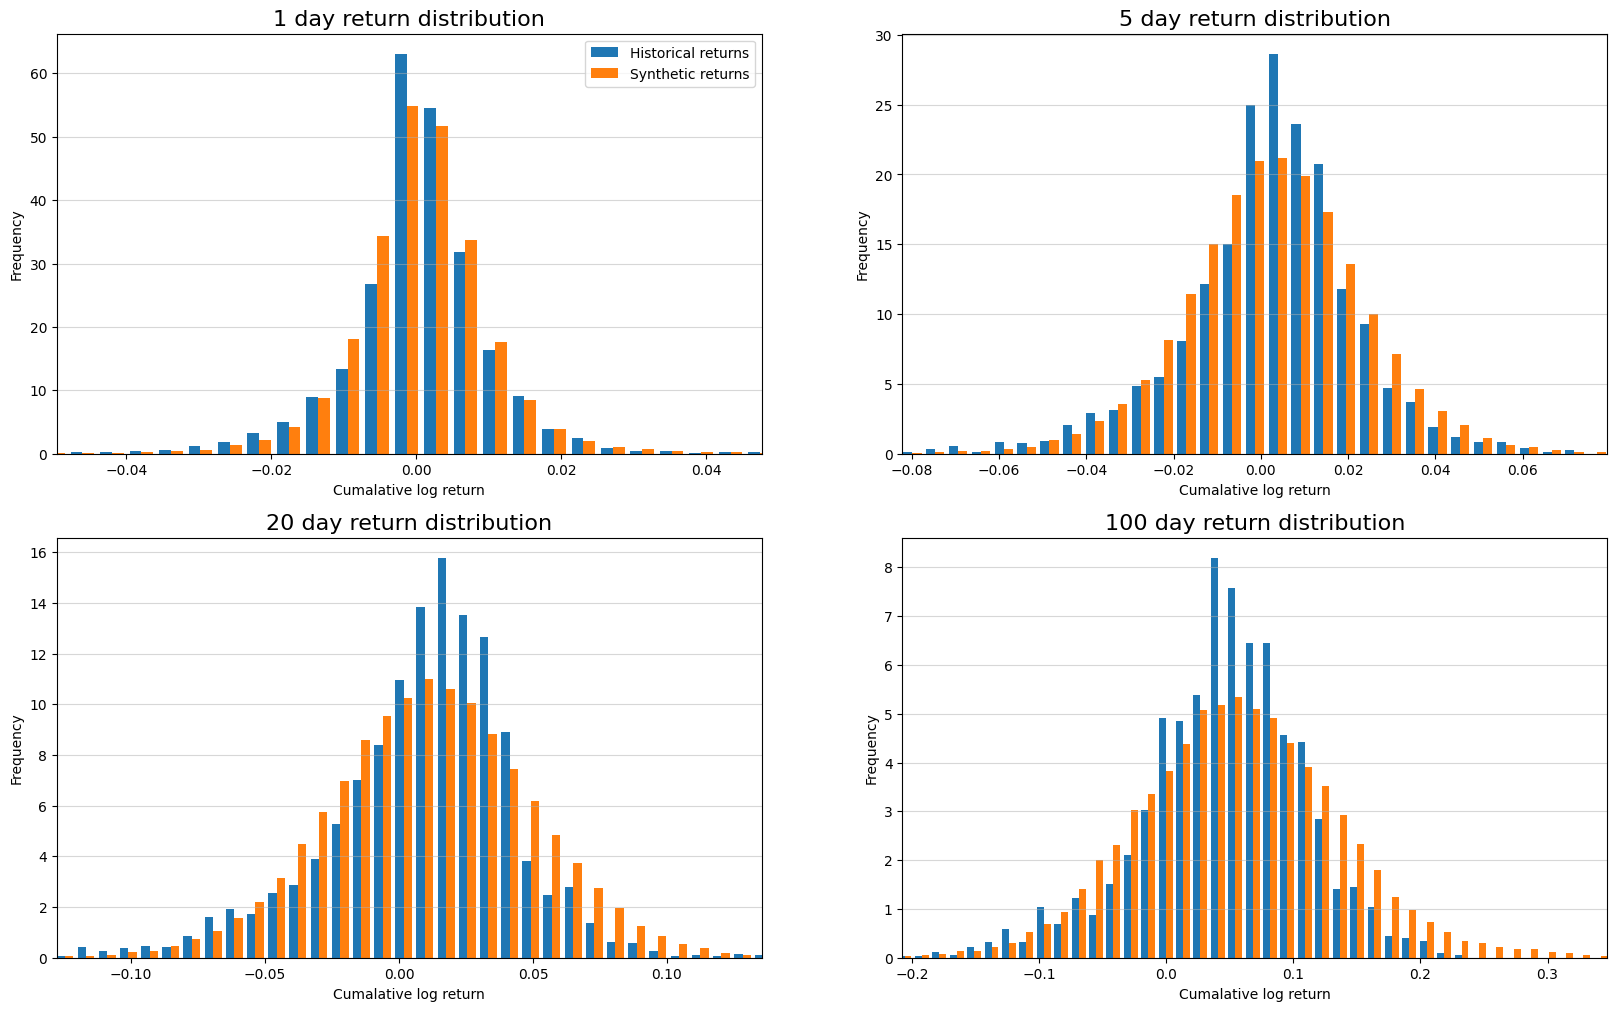

In [7]:
n_bins = 50
windows = [1, 5, 20, 100]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])

[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

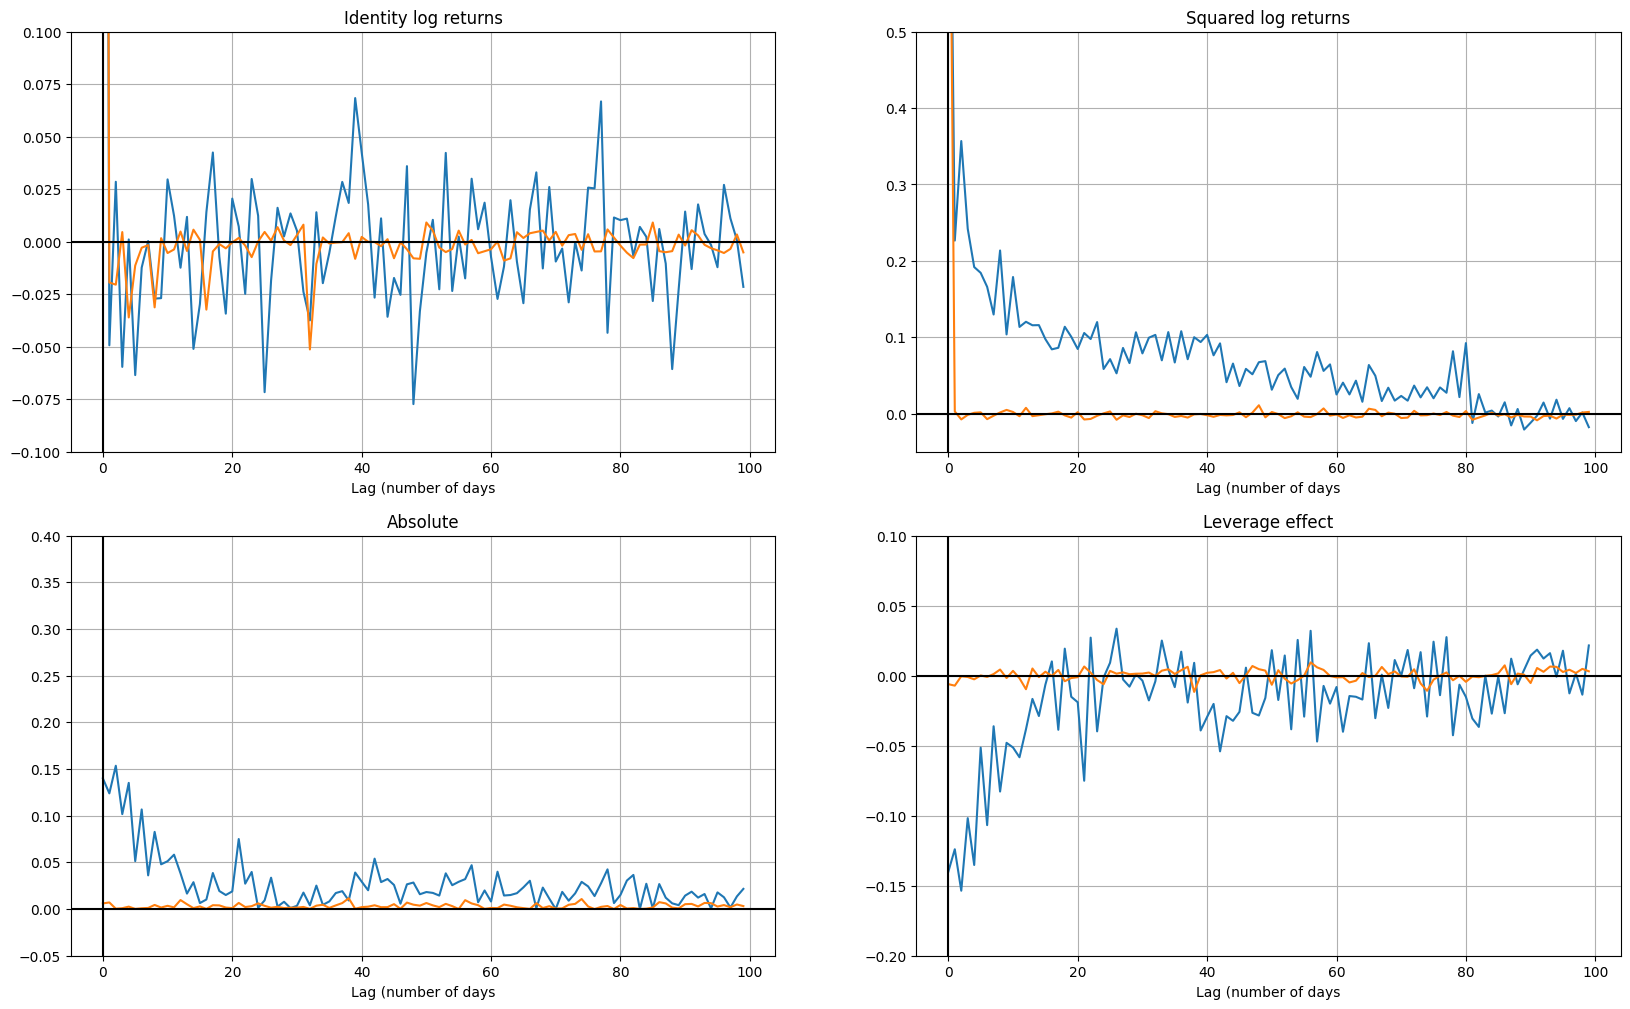

In [8]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')